# POC (d): show time series curve

## Copy request_api and mask function

In [1]:
import cdsapi
import time

# a wrapper function to request ERA5 API
# f_name: the name of the file to be requested
# shape: the ARBITRARY shape of the area to be requested
#        if None, the whole world will be queried
#        otherwise, the request ERA5 API with the bounding box of the shape
# return: the path of the file downloaded
def request_era5_api(f_name, shape=None, day = ['05']):
    fpath = f'data/download/{f_name}'
    if shape is None:
        area = [90, -180, -90, 180]
    else:
        west, sorth, east, north = shape.bounds
        area = [north, west, sorth, east]

    print('\n### ~~~~~~ ###')
    print('START requesting ERA5 API')
    start = time.time()

    c = cdsapi.Client()
    c.retrieve('reanalysis-era5-single-levels', {
        'product_type': 'reanalysis',
        'format': 'netcdf',
        'variable': '2m_temperature',
        'year': '2023',
        'month': '01',
        'day': day,
        'time': [
            '00:00',
            '01:00',
            '02:00',
            '03:00',
            '04:00',
            '05:00',
            '06:00',
            '07:00',
            '08:00',
            '09:00',
            '10:00',
            '11:00',
            '12:00',
            '13:00',
            '14:00',
            '15:00',
            '16:00',
            '17:00',
            '18:00',
            '19:00',
            '20:00',
            '21:00',
            '22:00',
            '23:00',
        ],
        'area': area,
    }, fpath)

    end = time.time()
    print(f'DONE requesting ERA5 API in {end - start} seconds')
    print('### ~~~~~~ ###\n')

    return fpath

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import folium
import time

# a function to mask the raster data with arbitrary shape
# fpath: the path of the raster data
# shape: the ARBITRARY shape
# return: the mask of the raster data, which is a boolean 2-D array
def shape_mask(fpath, shape):
    print('\n### ~~~~~~ ###')
    print('START masking raster data with arbitrary shape')
    start = time.time()

    gdf_shape = gpd.GeoDataFrame(geometry=[shape], crs=4326)

    ds = xr.open_dataset(fpath)
    print(f'shape of the whole raster data: {ds["t2m"].shape}')
    ds_2d = ds.isel(time=0)  # using a 2-D slice of the raster to construct the geospatail content of the pixels
    print(f'shape of the sliced raster data: {ds_2d["t2m"].shape}')

    # take a record of the lat/lon location in the raster data
    df_lat = pd.DataFrame(enumerate(ds_2d['latitude'].values), columns=['lat_index', 'latitude'])
    df_lon = pd.DataFrame(enumerate(ds_2d['longitude'].values), columns=['lon_index', 'longitude'])

    df_2d = ds_2d.to_dataframe()
    df_2d = df_2d.reset_index()
    df_2d = df_2d[['latitude', 'longitude', 't2m']]
    df_2d = df_2d.merge(df_lat, on='latitude')
    df_2d = df_2d.merge(df_lon, on='longitude')
    gdf_2d = gpd.GeoDataFrame(
        df_2d,
        geometry=gpd.points_from_xy(df_2d.longitude, df_2d.latitude),
        crs=4326,
    )  # construct the geospatail dataframe of the pixels
    gdf_masked = gdf_2d.sjoin(gdf_shape, how='inner', predicate="within")  # join the pixels with the shape, use GeoPandas spatial join

    # construct the mask of based on the lat/lon location of the pixels within the shape
    lat_index = gdf_masked['lat_index'].values
    lon_index = gdf_masked['lon_index'].values
    mask = np.zeros(ds_2d['t2m'].shape)
    mask[lat_index, lon_index] = 1
    mask = mask.astype(bool)

    end = time.time()
    print(f'DONE masking raster data with arbitrary shape in {end - start} seconds')
    print('### ~~~~~~ ###')

    # visualize the shape, all pixels and masked pixels
    m = gdf_shape.explore(name='shape', tiles='Stamen Terrain')
    gdf_2d.explore(m=m, column='t2m', name='api_request_points', cmap='Oranges')
    gdf_masked.explore(m=m, column='t2m', name='masked_points', cmap='Blues')
    folium.LayerControl().add_to(m)
    # m.save('poc_a_map.html')
    return mask, m

# Working example

### No functions implemented

### Use aggregation function in either:
1. a structural data way, provided by pandas, duckdb(sql), ...
2. a pure array way, provided by xarray

In [2]:
import geopandas as gpd

gdf = gpd.read_file('data/vector/greenland_main_island.geojson')  # read the shape from a geojson file
shape = gdf.loc[0, 'geometry']  # get an object of an arbitrary shape

# request ERA5 API for whole month
day = [str(i).zfill(2) for i in range(1, 32)]
fpath = request_era5_api('poc_d.nc', shape=shape, day=day)
mask, m = shape_mask(fpath, shape)


### ~~~~~~ ###
START requesting ERA5 API


2023-07-11 15:23:52,946 INFO Welcome to the CDS
2023-07-11 15:23:52,948 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-07-11 15:23:53,164 INFO Request is completed
2023-07-11 15:23:53,165 INFO Downloading https://download-0006-clone.copernicus-climate.eu/cache-compute-0006/cache/data5/adaptor.mars.internal-1689104633.8246036-2390-15-32e536ad-b290-472b-9f9c-1d30b52b1940.nc to data/download/poc_d.nc (33.2M)
2023-07-11 15:23:56,483 INFO Download rate 10M/s    


DONE requesting ERA5 API in 4.260375738143921 seconds
### ~~~~~~ ###


### ~~~~~~ ###
START masking raster data with arbitrary shape
shape of the whole raster data: (744, 96, 244)
shape of the sliced raster data: (96, 244)
DONE masking raster data with arbitrary shape in 0.2351219654083252 seconds
### ~~~~~~ ###


shape: (17_427_456, 4)
┌─────────────────────┬───────────┬────────────┬──────┐
│ time                ┆ latitude  ┆ longitude  ┆ t2m  │
│ ---                 ┆ ---       ┆ ---        ┆ ---  │
│ datetime[ns]        ┆ f32       ┆ f32        ┆ f32  │
╞═════════════════════╪═══════════╪════════════╪══════╡
│ 2023-01-01 00:00:00 ┆ 83.647003 ┆ -73.021004 ┆ null │
│ 2023-01-01 00:00:00 ┆ 83.647003 ┆ -72.770996 ┆ null │
│ 2023-01-01 00:00:00 ┆ 83.647003 ┆ -72.520988 ┆ null │
│ 2023-01-01 00:00:00 ┆ 83.647003 ┆ -72.270988 ┆ null │
│ …                   ┆ …         ┆ …          ┆ …    │
│ 2023-01-31 23:00:00 ┆ 59.896    ┆ -13.020012 ┆ null │
│ 2023-01-31 23:00:00 ┆ 59.896    ┆ -12.770008 ┆ null │
│ 2023-01-31 23:00:00 ┆ 59.896    ┆ -12.520004 ┆ null │
│ 2023-01-31 23:00:00 ┆ 59.896    ┆ -12.27     ┆ null │
└─────────────────────┴───────────┴────────────┴──────┘


<Axes: xlabel='day'>

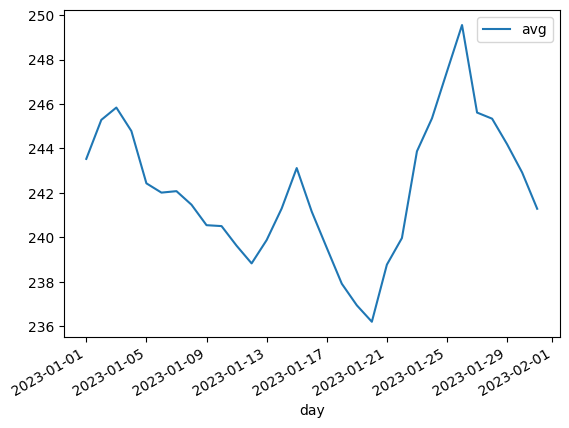

In [3]:
# 1. A tabuler data way

import duckdb
import xarray as xr
import polars as pl

ds = xr.open_dataset(fpath)
masked = ds.where(mask)  # mask the raster data with shape mask
pdf = pl.from_dataframe(masked['t2m'].to_dataframe().reset_index())  # flat the raster data into a table with schema: (time, latitude, longitude, t2m)
print(pdf)
sql = 'select date_trunc(\'day\', time) as day, avg(t2m) as avg from pdf group by date_trunc(\'day\', time)'
df = duckdb.query(sql).to_df()  # aggregate the table with sql
df.plot(x='day', y='avg')

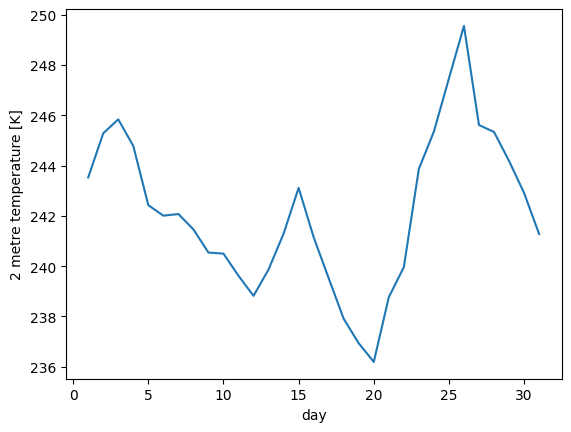

In [4]:
# 2. a pure array way

import xarray as xr

ds = xr.open_dataset(fpath)
masked = ds.where(mask)  # mask the raster data with shape mask

grouped = masked.groupby('time.day')  # groupby day
agg = grouped.mean(dim=['latitude', 'longitude', 'time'])  # aggregate each group by mean across latitude, longitude and time
agg['t2m'].plot()  # plot time series